# Task: Build Transformer (TF) for implementing SUBLEQ

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

## Here we show how a program specified by SUBLEQ commands can be implemented in our looped TF, and check whether our program works properly. This notebook is organized as below. 

In [2]:
## 1. Setup: Load the subleq commands & initial memory (from csv files), and specify the parameters
## 2. Run SUBLEQ manually
## 3. Run SUBLEQ using our TF architecture
## 4. Compare our TF SUBLEQ result & manual SUBLEQ result
## 5. Visualize the output of attention (after softmax)

## 1. Setup

### The shape of matrix X (input to TF)

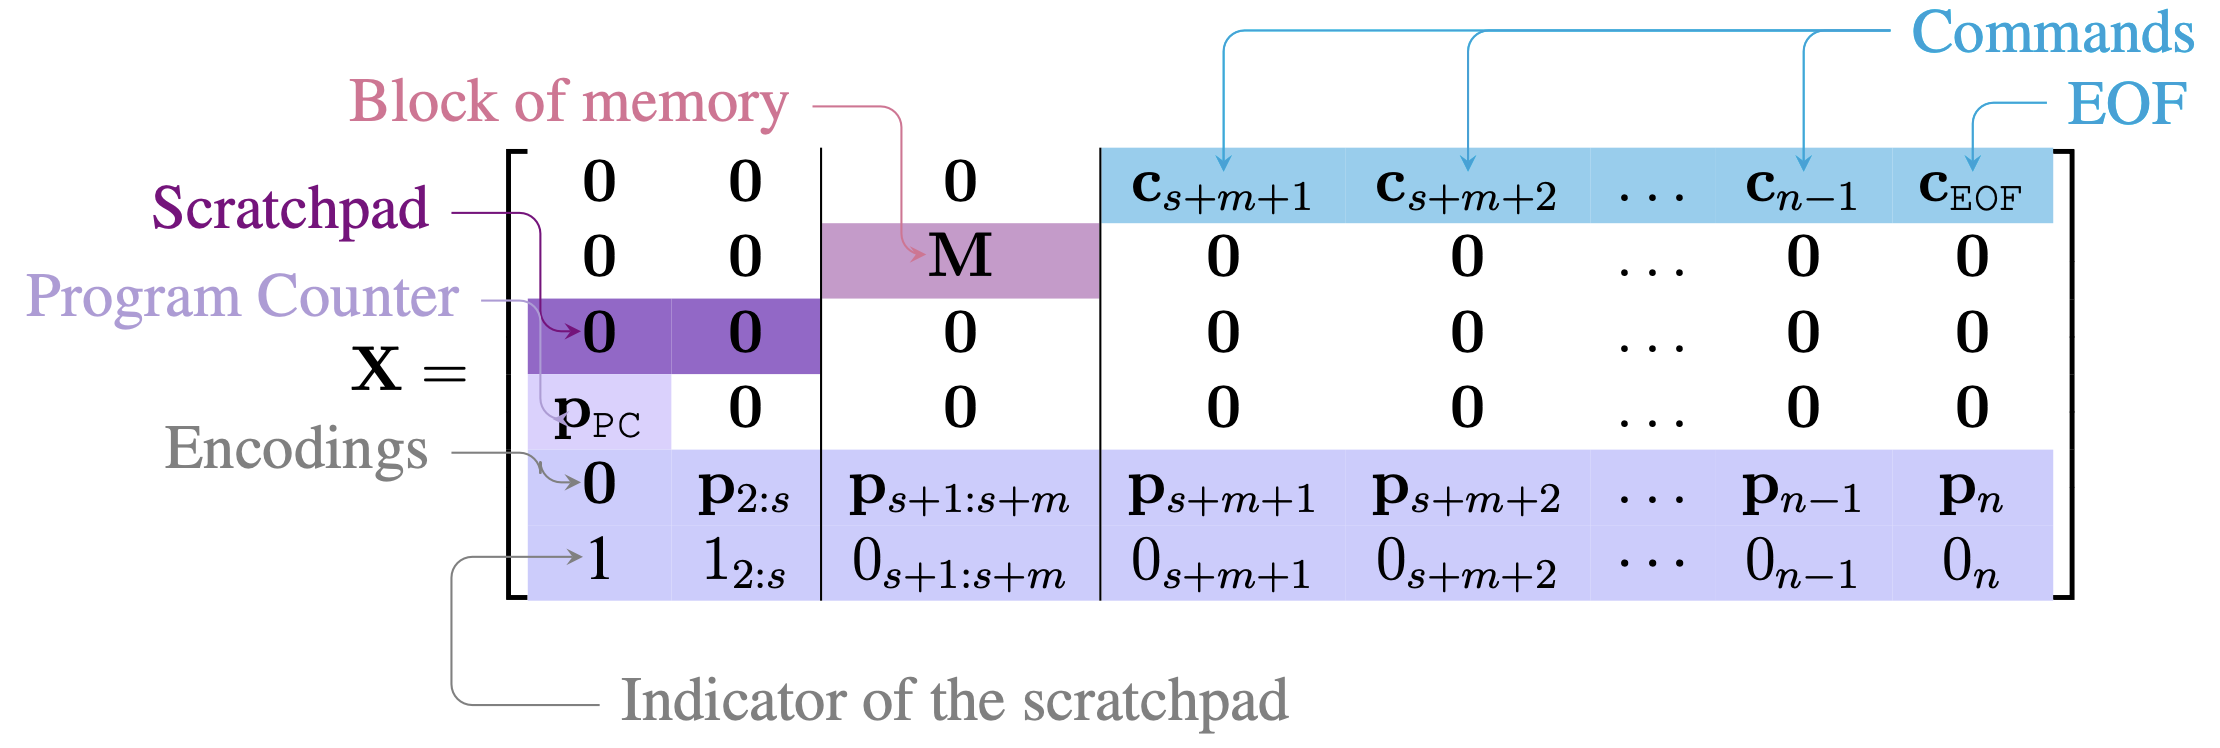

In [3]:
from IPython.display import Image
Image("img/input_X_to_TF.png")

### Specify the parameters for defining the matrix X (input to TF)

In [4]:
# s: number of columns in X for scratchpad
# m: number of columns in X for memory
# n: number of columns in X in total (for scratchpad, memory and commands)
# N: number of bits used to represent the integer values in each memory element
s,m,n,N = 8,8,32,8
logn = int(np.log2(n))

# Specify the number of rows of input X
# nrows_list: list of number of rows for each block (cmds, memory, scratchpad, program counter, positional encoding, buffer, indicator)
# row_idx_list: list of row index each block starts (memory, scratchpad, program counter, positional encoding, buffer) except cmds & indicator
from utils import get_nrows_subleq, get_row_idx_list_subleq
nrows_cmds, nrows_memory, nrows_scratchpad, nrows_pc, nrows_pos_enc, nrows_buffer = get_nrows_subleq(logn, N) 
num_rows_X = nrows_cmds + nrows_memory + nrows_scratchpad + nrows_pc + nrows_pos_enc + nrows_buffer + 1 
nrows_list = [nrows_cmds, nrows_memory, nrows_scratchpad, nrows_pc, nrows_pos_enc, nrows_buffer, 1] 
row_idx_list = get_row_idx_list_subleq(nrows_list) 
idx_memory, idx_scratchpad, idx_pc, idx_pos_enc, idx_buffer = row_idx_list

### Input text files: (1) the subleq commands, (2) the registers

In [5]:
# load the input files 
cmds_filename = 'inputs/subleq_cmds.csv'
cmds_df = pd.read_csv(cmds_filename)
cmds = cmds_df.to_numpy()
mem_filename = 'inputs/subleq_init_mem.csv'
mem_df = pd.read_csv(mem_filename)
mem = mem_df.to_numpy().reshape(-1,)

In [6]:
# check the validity of input files
for i in range(len(cmds)-1):
    (cmd_a, cmd_b, cmd_c) = cmds[i]
    assert(cmd_a >= s+2)   # a, b \in [s+2:s+m] except the final row, 
    assert(cmd_a < s+m)   
    assert(cmd_b >= s+2)
    assert(cmd_b < s+m)    
    assert(cmd_c >= s+m) # c \in [s+m:n]
    assert(cmd_c < n)    
    
assert((cmds[-1] == [s, s+1, n-1]).all()) # final row has (a, b, c) = (s, s+1, n-1)
assert(len(mem) == m) # mem should have $m$ elements
assert(mem[0] == 0) # mem[0] = 0
assert(mem[1] == -1) # mem[1] = -1

for i in range(len(mem)):
    assert(mem[i] <= 2**(N-2)-1)
    assert(mem[i] >= -2**(N-2))    

### Define the matrix X

In [7]:
from utils import init_input
X, _ = init_input(s,m,n,logn,N,num_rows_X,cmds,nrows_list,row_idx_list,opt=None,mem_given=mem)

## 2. Run SUBLEQ manually

In [8]:
num_loops = 30
from utils import run_manual_subleq
manual_subleq_results = run_manual_subleq(cmds, mem, s, m, n, N, num_loops=num_loops)

In [9]:
header = ['mem[0]']
for i in range(N-2):
    header.append('...')
header = np.append(header, ['mem[N-1]', 'a', 'b', 'c', 'mem[a]', 'mem[b]', 'mem[b]-mem[a]', 'flag', 'p-next'])
manual_subleq_results_df = pd.DataFrame(manual_subleq_results, columns=header)

## 3. Run SUBLEQ using our TF architecture

In [10]:
from subleq import read_inst, read_mem, subtract_mem, write_mem, conditional_branching, error_correction
import os
our_subleq_results = []
our_curr_result = [] 
lam=10 # lambda used for softmax in TF
dpi=200 #600

for i in range(num_loops):
    # Step 1. read instruction & check a, b, c 
    X1, our_curr_result, TF_read_inst = read_inst(X,s,m,n,logn,num_rows_X,N,i+1,nrows_list,row_idx_list,None,our_curr_result,lam) 
    # Step 2. read memory & check mem[a], mem[b]
    X2, our_curr_result, TF_mem = read_mem(X1,n,logn,num_rows_X,N,i+1,nrows_list,row_idx_list,None,our_curr_result,lam) 
    # Step 3. subtract memory & check mem[b]-mem[a] 
    X3, our_curr_result, *TF_subtract_mem = subtract_mem(X2,n,logn,num_rows_X,N,i+1,nrows_list,row_idx_list,None,our_curr_result,lam) 
    # Step 4. write memory 
    X4, our_curr_result, TF_write_mem = write_mem(X3,n,logn,num_rows_X,N,i+1,nrows_list,row_idx_list,None,our_curr_result,lam) 
    # Step 5. conditional branching & check flag, p_{next}
    X5, our_curr_result, *TF_cond_branch = conditional_branching(X4,n,logn,num_rows_X,N,i+1,nrows_list,row_idx_list,None,our_curr_result,lam) 
    # Step 6. error correction        
    X6, our_curr_result, TF_err_corr = error_correction(X5,n,logn,num_rows_X,N,i+1,nrows_list,row_idx_list,None,our_curr_result,lam) 

    X = X6 # go to the next loop
    our_subleq_results.append(tuple(our_curr_result))
    
    # save TF_mem figures 
    figRM1, figRM2 = TF_mem.save_heatmap('read memory, round {}'.format(i+1))
    list_path1 = ['jupyter_output_figs', 'read_memory', 'R{}_head_1'.format(i+1)]
    path1 = os.path.join(*list_path1)
    figRM1.savefig(path1, dpi=dpi)
    
    list_path2 = ['jupyter_output_figs', 'read_memory', 'R{}_head_2'.format(i+1)]
    path2 = os.path.join(*list_path2)
    figRM2.savefig(path2, dpi=dpi)
    
    # save TF_
    figRI = TF_read_inst.save_heatmap('read instruction, round {}'.format(i+1))
    list_path1 = ['jupyter_output_figs', 'read_instr', 'R{}'.format(i+1)]
    path1 = os.path.join(*list_path1)
    figRI.savefig(path1, dpi=dpi)  
our_subleq_results_df = pd.DataFrame(our_subleq_results, columns=header)

## 4. Compare our TF SUBLEQ result & manual SUBLEQ result

In [11]:
from utils import compare_TF_and_manual
compare_TF_and_manual(manual_subleq_results, our_subleq_results)

TF SUBLEQ is working properly!


## 5. Visualize the output of attention (after softmax)

### make GIF for read_memory (head 1, 2) result for multiple rounds

In [12]:
from PIL import Image
import glob
import os
# Create the frames
frames = []
imgs = sorted(glob.glob('jupyter_output_figs/read_memory/*.png'), key=os.path.getmtime)
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
    
# Save into a GIF file that loops forever
frames[0].save('jupyter_output_figs/read_mem.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

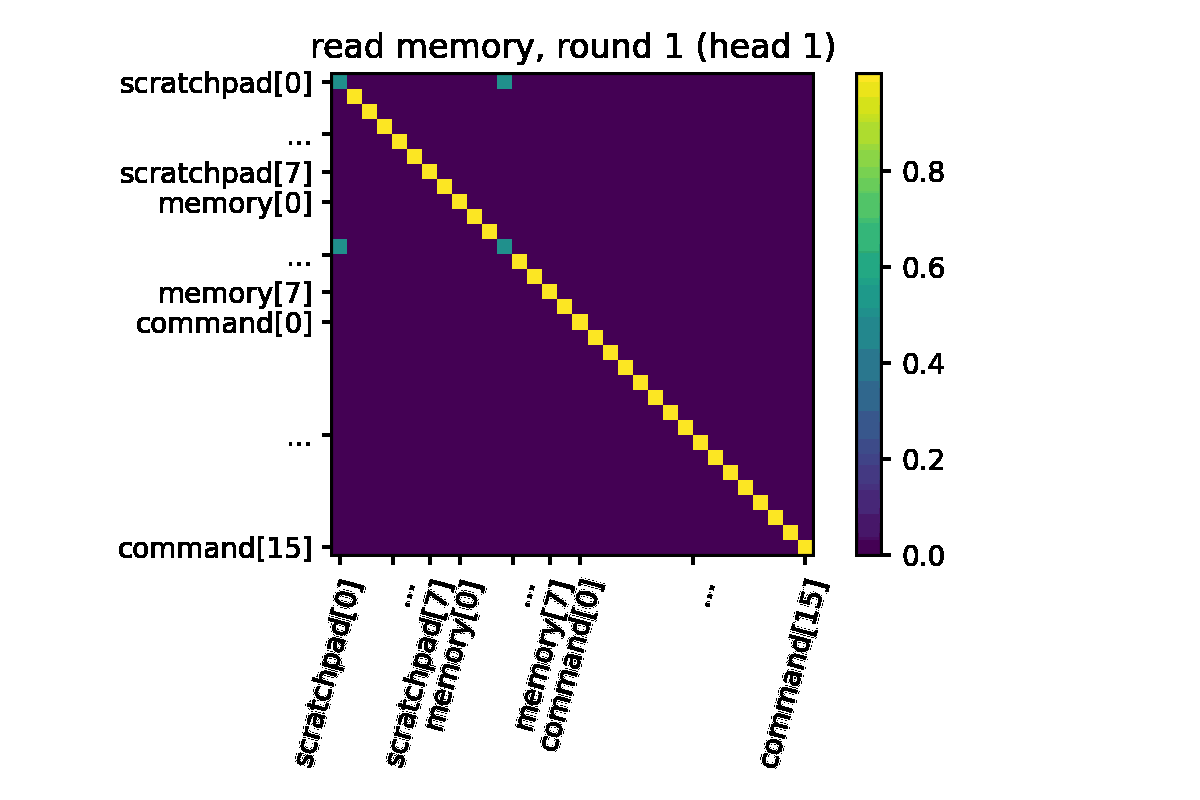

In [13]:
from IPython.display import Image
Image(open('jupyter_output_figs/read_mem.gif','rb').read())

### make GIF for read_instruction result for multiple rounds

In [14]:
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = sorted(glob.glob('jupyter_output_figs/read_instr/*.png'), key=os.path.getmtime)
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
    
# Save into a GIF file that loops forever
frames[0].save('jupyter_output_figs/read_instr.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=200, loop=0)

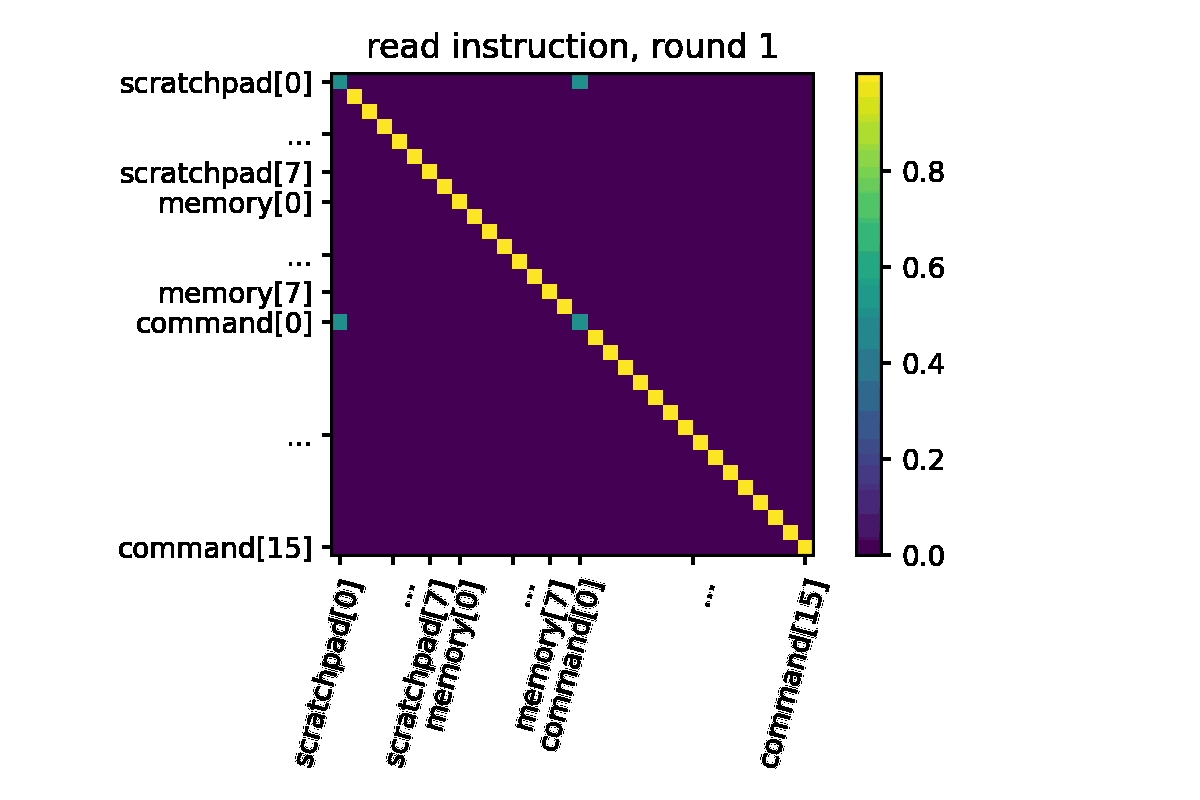

In [15]:
from IPython.display import Image
Image(open('jupyter_output_figs/read_instr.gif','rb').read())